In [1]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.data.download_data import *
from src.data.fire_data import *
from src.data.read_data import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.features.build_features import *
from src.models.train_model import *
import seaborn as sns
output_notebook()
# set font size 
from src.visualization.visualize import *
from src.models.train_model import *


Loading BokehJS ...

{'test_r2_score': 0.9678402677630003, 'test_mean_squared_error': 25.135610517304375}
data no fire has shape (77746, 15)


Text(0, 0.5, 'PM2.5')

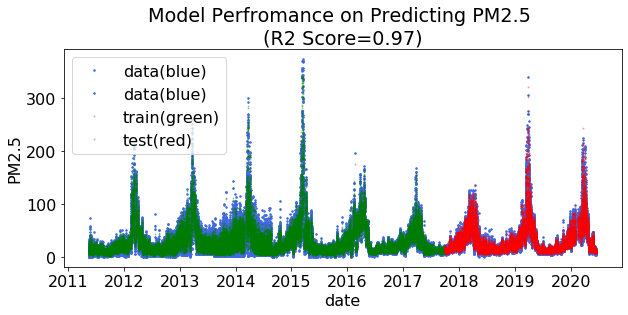

In [7]:
# load data and model 
data = Dataset('Chiang Mai')
data.load_()
pollutant = 'PM2.5'
# load model meta 
with open(data.model_folder + 'model_meta.json') as f:
    model_meta = json.load(f)[pollutant]
    
print(model_meta['rf_score'])

data.x_cols = model_meta['x_cols']
data.fire_dict = model_meta['fire_dict']

# build dataset 
data.feature_no_fire()
data.pollutant = pollutant
data.merge_fire(data.fire_dict)

rf_model = pickle.load(open(data.model_folder +f'PM25_rf_model.pkl','rb'))

data.split_data(split_ratio=[0.7, 0.3])
trn_index = data.split_list[0]
test_index = data.split_list[1]

xtrn, ytrn, x_cols = data.get_data_matrix(use_index=trn_index,x_cols=data.x_cols)
xtest, ytest, _ = data.get_data_matrix(use_index=test_index,x_cols=data.x_cols)

plt.figure(figsize=(10, 4))

# plot data 
plt.plot(trn_index,ytrn, marker='.', label='data(blue)',linewidth=0,alpha=1, markersize=3,color='royalblue')
plt.plot(test_index,ytest, marker='.', label='data(blue)',linewidth=0,alpha=1, markersize=3,color='royalblue')

plt.plot(trn_index,rf_model.predict(xtrn), marker='.', label='train(green)',linewidth=0,alpha=0.3, markersize=2,color='green')
plt.plot(test_index,rf_model.predict(xtest), marker='.', label='test(red)',linewidth=0,alpha=0.3, markersize=2, color='red')
 
plt.legend()
plt.title('Model Perfromance on Predicting PM2.5 \n(R2 Score=0.97)')
plt.xlabel('date')
plt.ylabel('PM2.5')

In [15]:
trn_data = data.data.loc[trn_index]
test_data = data.data.loc[test_index]

wea_cols = ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)',
       'PM2.5_lag_1', 'wind_CALM', 'wind_E', 'wind_N', 'wind_S', 'wind_W',
       'is_rain']

fire_cols = ['fire_0_100', 'fire_100_400', 'fire_400_700', 'fire_700_1000','PM2.5_lag_1']
# datetime information cols use the data from the test set 
date_cols = ['is_holiday', 'is_weekend', 'day_of_week', 'time_of_day']

wea = trn_data[wea_cols]
fire = trn_data[fire_cols]

In [179]:
n_samples = 100

year_list = trn_data.index.year.unique()
year_sam = np.arange(len(year_list)) + 1
year_sam = year_sam.cumsum()/year_sam.cumsum().sum()
year_sam = (year_sam*n_samples).astype(int)
year_sam

array([ 1,  3,  7, 11, 17, 25, 33])

In [37]:
# add datetimes columns for weather and fire data for the training data 
wea['year'] = wea.index.year
wea['day_of_year'] = wea.index.dayofyear
wea['hour'] = wea.index.hour

fire['year'] = fire.index.year
fire['day_of_year'] = fire.index.dayofyear
fire['hour'] = fire.index.hour

In [178]:
time_range = pd.date_range(start=test_data.index.min(), end=test_data.index.max(), freq='h')

In [180]:
def get_sample(test_datetime, wea, fire,year_list, year_samples, day_err=15, hour_err=1):
    """Randomsamples data in each columns 
    Args:
    
    Returns: 
    
    """
    
    #get date range
    start_date = test_datetime - pd.Timedelta(f'{day_err} days')
    end_date = test_datetime + pd.Timedelta(f'{day_err} days')
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    date_range = date_range.dayofyear.to_list()
     
    # get hour range 
    start_date = test_datetime - pd.Timedelta(f'{hour_err} hours')
    end_date = test_datetime + pd.Timedelta(f'{hour_err} hours')
    hour_range = pd.date_range(start=start_date, end=end_date, freq='h')
    hour_range = hour_range.hour
    
    # get wether sample 
    # select the data
    fire_samples = []
    wea_samples = []
    for year, year_sample in zip(year_list, year_samples):
        # select deata for the year
        wea_sam = wea[(wea['year']==year) & wea['day_of_year'].isin(date_range) & wea['hour'].isin(hour_range)]
         
        if len(wea_sam) > 0:
             wea_samples.append(wea_sam.sample(year_sample,replace=True))
            
        # select deata for the year
        fire_sam = fire[(fire['year']==year) & fire['day_of_year'].isin(date_range) & fire['hour'].isin(hour_range)]
     
        if len(fire_sam) > 0:
             fire_samples.append(fire_sam.sample(year_sample,replace=True))

    wea_samples = pd.concat(wea_samples, ignore_index=True).sample(frac=1).reset_index(drop=True)
    fire_samples = pd.concat(fire_samples, ignore_index=True).sample(frac=1).reset_index(drop=True)
    wea_samples['datetime'] = test_datetime
    
    data_samples = pd.concat([wea_samples, fire_samples], axis=1)
    
    return data_samples.drop(['day_of_year','hour','year'],axis=1)

In [181]:
%%time

data_samples_all = []
data_samples_len = []
for test_datetime in tqdm(time_range):
    
    data_samples = get_sample(test_datetime, wea, fire,year_list, year_samples=year_sam)
    data_samples_all.append(data_samples)
    data_samples_len.append(len(data_samples))
    
data_samples_all = pd.concat(data_samples_all,ignore_index=True)
# add calenda information 
data_samples_all = data_samples_all.set_index('datetime')
data_samples_all = add_calendar_info(data_samples_all)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 23718/23718 [16:17<00:00, 24.26it/s]


Wall time: 16min 27s


In [182]:
x = data_samples_all[x_cols].values
ypred = rf_model.predict(x)
ypred_df = pd.Series(ypred , index=data_samples_all.index)
ypred_df.head()

[autoreload of src.visualization.visualize failed: Traceback (most recent call last):
  File "c:\users\benny\pyenv\geo\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "c:\users\benny\pyenv\geo\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Program Files\Python37\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Program Files\Python37\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "..\src\visualization\visualize.py", line 127, in <module>
    for i, _ in enumerate(ax):
NameError: name 'ax' is not defined
]


datetime
2017-10-01     8.346205
2017-10-01    26.530894
2017-10-01    25.089568
2017-10-01    24.044503
2017-10-01    24.044654
dtype: float64

In [187]:
mid_band = ypred_df.groupby(level=0).median()
upper_band = ypred_df.groupby(level=0).quantile(q=0.95)
lower_band = ypred_df.groupby(level=0).quantile(q=0.05)

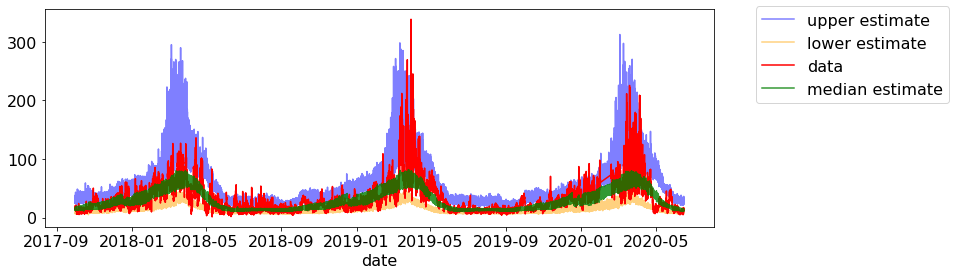

In [200]:
plt.figure(figsize=(12,4))
#ypred_df.plot(alpha=0.3,color='royalblue')

plt.plot(upper_band,color='blue',label='upper estimate',alpha=0.5)
plt.plot(lower_band,color='orange',label='lower estimate',alpha=0.5)

plt.plot(test_index, ytest,color='red',label='data')
plt.plot(mid_band,color='green',label='median estimate',alpha=0.8)


plt.xlabel('date')
plt.legend(bbox_to_anchor=(1.05, 1.05),frameon=True)
